## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled price data from FRED (which sources data from the BLS) and adjusted it using the CPI. Data sources are here:

- [CPI (for inflation)](https://fred.stlouisfed.org/series/CPIAUCSL)
- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

**A note here**: I couldn't for the life of me, find any data that goes back to 1935, like Fox cites in the article. The earliest history I could find from FRED or the BLS only goes back to the 80s, so I must be missing something!

The following graphic shows to historic prices (adjusted for inflation) of the 3 types of meats described.

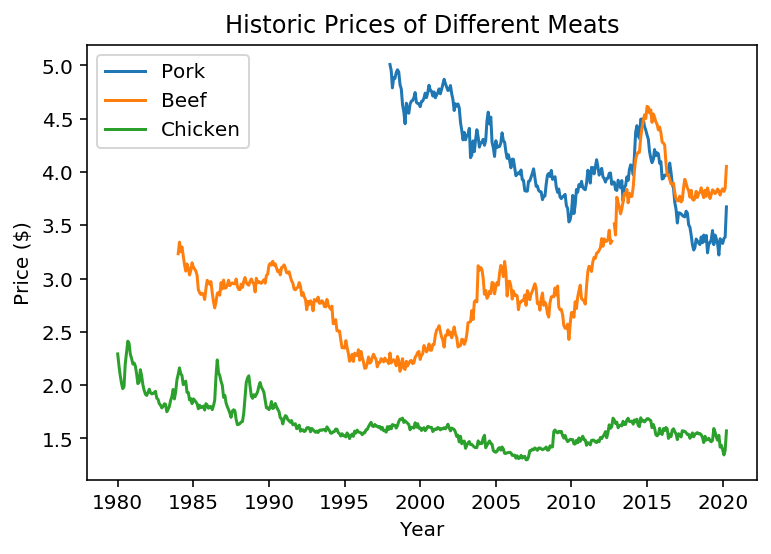

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = pd.read_csv('data/CPIAUCSL.csv')

# Get most recent cpi
MOST_RECENT = cpi.loc[cpi['DATE'] == cpi['DATE'].max(), 'CPIAUCSL'].values[0]

df = (
    beef()
    .pipe(pd.merge, chicken(), how='outer')
    .pipe(pd.merge, pork(), how='outer')
    .pipe(pd.merge, cpi, how='outer', on='DATE')
    .rename(columns={'APU0000703112':'beef',
                     'APU0000706111':'chicken',
                     'APU0000FD3101':'pork',
                     'CPIAUCSL':'cpi',
                     'DATE':'date'})
)

df['date'] = pd.to_datetime(df['date'])
df['beef'] = pd.to_numeric(df['beef'],errors='coerce')
df.sort_values(by=['date'], inplace=True)

df['new_pork'] = apply_adjust(df, 'pork', MOST_RECENT)
df['new_chicken'] = apply_adjust(df, 'chicken', MOST_RECENT)
df['new_beef'] = apply_adjust(df, 'beef', MOST_RECENT)

plt.plot(df['date'], df['new_pork'], label='Pork');
plt.plot(df['date'], df['new_beef'], label='Beef');
plt.plot(df['date'], df['new_chicken'], label='Chicken');

plt.legend(loc="upper left");
plt.xlabel("Year");
plt.ylabel("Price ($)")
plt.title("Historic Prices of Different Meats");

In order to summarize the price change since the historic price, I'll simply take the percentage difference between the oldest and most recent price.

## Claims

> "poultry costs U.S. consumers 62% less in inflation-adjusted terms than it did in 1935"

> "Pork, now also raised mostly at factory scale indoors, is 12% cheaper"

> "Beef, which isn’t, costs 63% more."

Here's what I found:

- From 1980 - 2020, chicken prices have declined 31.5%.
- From 1998 - 2020, the price of pork has declined 26%.
- From 1984 - 2020, the price of beef has increased 25.3%.

In [5]:
# Comparing claims
TYPES = ['chicken', 'pork', 'beef']

diff = pd.DataFrame({
    'type':TYPES,
    'mine':[get_diff(df, x, True) for x in TYPES],
    'his' :[-.62, -.12, .63]
})
diff['diff'] = diff['mine'] - diff['his']
# print(diff.to_markdown())

|    | type    |      mine |   his |      diff |
|---:|:--------|----------:|------:|----------:|
|  0 | chicken | -0.314954 | -0.62 |  0.305046 |
|  1 | pork    | -0.266726 | -0.12 | -0.146726 |
|  2 | beef    |  0.253233 |  0.63 | -0.376767 |

## Market Reactions

- Where do we define "coronavirus is here"
- Look at pct change in price for all 3 items

## Final Notes

- Maybe I deflated prices using a different CPI than the author
- My numbers certainly aren't in the same date range?